In [1]:
import importlib
import itertools
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable

np.random.seed(33333)
torch.manual_seed(33333)
%matplotlib inline

In [33]:
import analysis
import razor_data
import toy_data
import plotting
import gp
importlib.reload(analysis);
importlib.reload(razor_data);
importlib.reload(toy_data);
importlib.reload(plotting);

In [23]:
def fit_signal(
        box, btags, sms,                                # analysis region
        num_mr_bins, mr_max,                            # fit range
        k_ell=200, k_alpha=200,                         # kernel parameters
        steps=1000, lr=0.001,                           # fit parameters
        hmc_epsilon=0.0001, hmc_L_max=10,               # HMC parameters
        num_samples=40000, verbose=False): 
    """
    Performs a signal + background fit using a fixed signal shape.
    """
    data = analysis.get_data(box, btags, num_mr_bins, mr_max)
    data_sig = analysis.get_data(box, btags, num_mr_bins, mr_max, 
                                 proc=sms)
    U = data['u']
    Y = data['y']
    # inject signal into the data
    S_mean = data_sig['y']
    Y = Y + torch.Tensor(np.random.poisson(S_mean.numpy()))
    
    kernel = gp.SquaredExponentialKernel(k_ell, k_alpha)
    G = gp.PoissonGPWithSignal(kernel, U, Y, S_mean,
            hmc_epsilon=hmc_epsilon, hmc_L_max=hmc_L_max)
    G.fit(num_steps=steps, lr=lr, verbose=verbose)

    return G

In [56]:
box = 'SevenJet'
btags = 2
num_mr_bins = 50
mr_max = 4000
sms = 'T1tttt_1800_100'

k_ell = 800
k_alpha = 150
G = fit_signal(box, btags, sms, num_mr_bins, mr_max, verbose=True,
              k_ell=k_ell, k_alpha=k_alpha)

Iteration 0 of 1000
Iteration 100 of 1000
Iteration 200 of 1000
Iteration 300 of 1000
Iteration 400 of 1000
Iteration 500 of 1000
Iteration 600 of 1000
Iteration 700 of 1000
Iteration 800 of 1000
Iteration 900 of 1000


In [61]:
samples = G.sample(40000, verbose=True)

Beginning HMC iterations with epsilon=0.0001, L_max=10
2000: Accepted steps: 1805, Rejected steps: 195 (0 bad)
4000: Accepted steps: 3585, Rejected steps: 415 (0 bad)
6000: Accepted steps: 5388, Rejected steps: 612 (0 bad)
8000: Accepted steps: 7147, Rejected steps: 853 (0 bad)
10000: Accepted steps: 8937, Rejected steps: 1063 (0 bad)
12000: Accepted steps: 10703, Rejected steps: 1297 (0 bad)
14000: Accepted steps: 12508, Rejected steps: 1492 (0 bad)
16000: Accepted steps: 14313, Rejected steps: 1687 (0 bad)
18000: Accepted steps: 16101, Rejected steps: 1899 (0 bad)
20000: Accepted steps: 17900, Rejected steps: 2100 (0 bad)
22000: Accepted steps: 19704, Rejected steps: 2296 (0 bad)
24000: Accepted steps: 21466, Rejected steps: 2534 (0 bad)
26000: Accepted steps: 23234, Rejected steps: 2766 (0 bad)
28000: Accepted steps: 25012, Rejected steps: 2988 (0 bad)
30000: Accepted steps: 26800, Rejected steps: 3200 (0 bad)
32000: Accepted steps: 28617, Rejected steps: 3383 (0 bad)
34000: Accepte

In [62]:
samples_withsignal = G.preds_from_samples(include_signal=True)

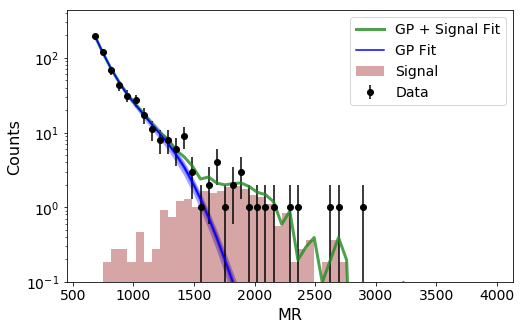

In [63]:
importlib.reload(plotting);
plotting.plot_hist_1d(U=G.U.data, Y=G.Y.data, S=G.S.data, samples=samples, samples_withsignal=samples_withsignal)

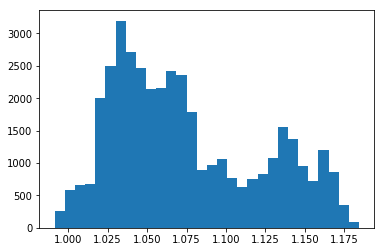

In [64]:
plt.hist(np.concatenate([np.exp(s[0]) for s in G.log_signal_samples]), bins=30);